# Feature selection in strength prediction with ANN

Copyright 2020 -
Leon Kellner, Merten Stender, Hamburg University of Technology, Germany

https://www2.tuhh.de/skf/

https://cgi.tu-harburg.de/~dynwww/cgi-bin/home/

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation,
either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

## 0.1 Packages

In [25]:
# data handling modules
import pandas as pd
import numpy as np

# machine learning modules - pre- & postprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# machine learning modules - ANN
from tensorflow import keras
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import RMSprop, SGD

# explainable AI
import shap

# visualization
from matplotlib import pyplot as plt
import seaborn as sns

# other
import importlib

# inhouse modules
import auxiliary_functions as aux  # repeatedly used functions are outsourced to this module
import data_preprocessing as dp    # data preprocessing module
importlib.reload(dp)  # automatic reload (sometimes needed)
importlib.reload(aux)

<module 'auxiliary_functions' from 'D:\\05_Feature_selection\\feature-selection-2020-paper\\auxiliary_functions.py'>

## 0.2 Variables and constants

In [26]:
# control variables - data cleaning
onehot_ = False        # one-hot encode data t/f
freshwater_ = False    # only use freshwater ice data t/f
drop_nan_ = True       # drop all rows that contain nan values after data cleaning t/f, necessary for ANN
exp_cat_ = False       # Take exponential of ordinally encoded categorical data to increase distance between categories
drop_outlier_ = 0      # drop values > this value in strength values 
if freshwater_ == True : drop_outlier_ = 75.0 
transform_y = True     # transform target values for better prediction

# contral variables - code execution
use_kfold = True      # check for overfitting with kfold cross validation
exploratory = False    # do exploratory data analysis  y/n
random_state_ = 7

# global training constants and hyperparameters
LOSS_OBJECTIVE = 'mean_absolute_error'
#LOSS_OBJECTIVE = 'mean_squared_logarithmic_error'
METRICS = ['mse', 'mae']  # last metric in this list is used for early stopping
BATCH_SIZE = 128
EPOCHS = 400  # doesn't need to be a high number due to early stopping, but keep an eye on training process
EARLY_STOPPING_PATIENCE = 5

# some general variables for postprocessing
dpi_ = 1000                     # resolution for figures
fig_size_ = aux.cm2inch(12, 8)  # figure size

# file name templates for saving files, figures and models
fig_path_name_template = "raw_figures/rgsr_ann_sw_"    
excel_path_name_template = 'excel_outputs/rgsr_ann_sw_'
if freshwater_:
    fig_path_name_template = "raw_figures/rgsr_ann_fw_"
    excel_path_name_template = 'excel_outputs/rgsr_ann_fw_'

## 1. Import and prepare data

In [27]:
file = 'data points_v1.12.xlsx'
data = dp.data_cleaning(filename=file)  # method agnostic initial data cleaning

# method specific data cleaning & split into encoded and non-encoded data
# Display datasets are not encoded or scaled, and will be used in visualization later
X, y, X_display, y_display = dp.data_prep_strength_pred(data, freshwater=freshwater_, onehot=onehot_, 
                                                        drop_nan=drop_nan_, drop_outlier=drop_outlier_, exp_cat=exp_cat_) 

# transform target values for better prediction (strength is almost log-normally distributed)
if transform_y: y = dp.transform_target(y, back=False) 

# if mean square log error is used, y cannot contain negative values
if LOSS_OBJECTIVE == "mean_squared_logarithmic_error":  
    assert not any(y < 0)  # assert that not any value in y is negative

num_features = X.shape[1]
num_samples = data.shape[0]

# train, test, and validation splits
split = 0.2
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=split, shuffle=True, random_state=random_state_)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=split, shuffle=True, random_state=random_state_)

# standardize / normalize features
# this should be done after splitting and by fitting the scaler to training data only
scaler = dp.fit_scaler_num_features(X_train, method='normalize')  # fit scaler to train data only
X, X_train_val, X_test = dp.scale_num_features(X, scaler), dp.scale_num_features(X_train_val, scaler), dp.scale_num_features(X_test, scaler)
X_train, X_val = dp.scale_num_features(X_train, scaler), dp.scale_num_features(X_val, scaler)

# tidy features names for later visualizations 
if freshwater_:
    name_map = {
        "strain_rate": "Strain rate",
        "triaxiality": "Triaxiality",
        "temperature": "Temperature",
        "volume": "Volume",
        "grain_size": "Grain size", 
        "type_test": "Type of test",
        "columnar_loading": "Columnar loading",
        "type_ice": "Type of ice",
    }
else:
    name_map = {
        "temperature": "Temperature",
        "columnar_loading": "Columnar loading",
        "strain_rate": "Strain rate",
        "type_ice": "Type of ice",
        "volume": "Volume",
        "type_test": "Type of test",
        "salinity": "Salinity", 
        "triaxiality": "Triaxiality",
    }
display_feature_names = list(map(lambda x: name_map.get(x, x), X.columns))

X.head()

Encoded columnar loading:  along  =  2.0
Encoded type of ice:  columnar  =  0.0


,type_test,strain_rate,temperature,salinity,type_ice,columnar_loading,triaxiality,volume
original_index,,,,,,,,
46,1.0,0.391224,0.421687,0.453613,0.0,1.0,1.0,0.15832
47,1.0,0.257783,0.421687,0.436887,0.0,0.5,1.0,0.15832
48,1.0,0.237784,0.413655,0.503791,0.0,1.0,1.0,0.15832
49,1.0,0.233437,0.397590,0.414585,0.0,1.0,1.0,0.15832
51,1.0,0.232008,0.598394,0.403434,0.0,1.0,1.0,0.15832


## 1.1 Exploratory data analysis

In [28]:
if exploratory:
    # check and output shapes and features
    print(X.shape, y.shape, X_display.shape, y_display.shape)   
    #X.head()
    #X_display.head()

    print(f'number of input feautures: {num_features}')
    print(f'number of samples (overall): {num_samples}')

    # a histogram of all inputs
    hist_inputs = X.hist(layout=(3,3), figsize=(10,10));
    plt.show()

    # a histogram of all outputs
    print('targets: number of behavior type 1: ' + str(np.sum(y)))
    print('targets: number of behavior type 0: ' + str(len(y)-np.sum(y)))
    print('the imbalance is: ' + str(np.sum(y)/y.shape*100) + ':' + str((len(y)-np.sum(y))/y.shape*100))
    print('the expected value is:' + str(np.round(np.mean(y),2)))
    hist_outputs = y.hist();
    plt.xlabel('target value transformed')
    plt.show()
    if transform_y:
        hist_outputs = dp.transform_target(y, back=True).hist();
        plt.xlabel('target value non-transformed')
        plt.show()
    
    # boxplot of strength values to detect outliers
    sns.boxplot(x=y)
    plt.show()
    if transform_y:
        sns.boxplot(x=dp.transform_target(y, back=True))
        plt.show()

## 2. ANN model preparation and cross-validation

In [29]:
# --- model building

# Wrap model building for baseline model
def build_model_baseline(n_hidden=2, n_neurons=30, learning_rate=1e-3, input_shape_=[num_features]):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=input_shape_))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1, activation="linear"))  # linear activation for output layer for regression
    model.compile(loss=LOSS_OBJECTIVE,
                  optimizer=RMSprop(lr=learning_rate),
                  metrics=METRICS)
    return model

# optimized model with hyperparameters from keras-tuner RandomSearch optimization
# see strength_ANN_opti_vX.X.ipynb
def build_model_optimized(input_shape_=[num_features]):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=input_shape_))
    model.add(Dense(units=64, activation="relu"))
    model.add(Dense(units=64, activation="relu"))
    model.add(Dense(units=64, activation="relu"))
    model.add(Dense(1, activation="linear"))  # linear activation for output layer for regression
    model.compile(loss=LOSS_OBJECTIVE,
             optimizer=SGD(lr=0.1, momentum=0.9),
             metrics=METRICS)
    return model

model = build_model_optimized()

# early stopping
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss',  
                                         min_delta=0,                    
                                         patience=EARLY_STOPPING_PATIENCE,
                                         verbose=0, mode='auto')

# --- use cross validation to find out whether the model architecture is well suited for the problem
if use_kfold:
    metrics_cv = {'mse_loss': [], 'rmse': [], 'mse': [], 'mae': []}  # store crossvalidation results in a dict
    kfold = KFold(n_splits=5, shuffle=True)
    for train, test in kfold.split(X_train_val, y_train_val):
        
        # split fold test data into validation set for early stopping and test set for performance evaluation
        Xfold_eval, Xfold_test, yfold_eval, yfold_test = train_test_split(X_train_val.iloc[test, :], y_train_val.iloc[test], test_size=0.5, shuffle=True)
        history = model.fit(X_train_val.iloc[train,:], y_train_val.iloc[train], 
                  batch_size=BATCH_SIZE, epochs=EPOCHS, 
                  verbose=0, callbacks=[callback], validation_data = (Xfold_eval, yfold_eval)) 
        yfold_predict = model.predict(Xfold_test)
        
        if transform_y:
            # transform predicted and test target values back for better interpretation of results
            yfold_test = dp.transform_target(yfold_test, back=True)
            yfold_predict = dp.transform_target(yfold_predict, back=True)
            
        current_metrics = aux.regression_metrics(yfold_predict, yfold_test)
        metrics_cv['mse'].append(current_metrics['mse'])
        metrics_cv['rmse'].append(current_metrics['rmse'])
        metrics_cv['mae'].append(current_metrics['mae'])
        
        # current keras metrics on non-transformed targets y
        current_metrics = model.evaluate(Xfold_test, yfold_test, verbose=0)  
        metrics_cv['mse_loss'].append(current_metrics[0])

    # add mean of kfold metric values
    metrics_cv['mse_loss_mean'] = np.mean(metrics_cv['mse_loss'])
    metrics_cv['mse_mean'] = np.mean(metrics_cv['mse'])
    metrics_cv['rmse_mean'] = np.mean(metrics_cv['rmse'])
    metrics_cv['mae_mean'] = np.mean(metrics_cv['mae'])
    
    # report the CV results
    print('cross-validation performance RMSE :', np.round(metrics_cv['rmse'], 2), ', mean: ', str(np.round(metrics_cv['rmse_mean'], 2)), ', SD +/-: ', str(np.std(metrics_cv['rmse'])))
    print('cross-validation performance MAE :', np.round(metrics_cv['mae'], 2), ', mean: ', str(np.round(metrics_cv['mae_mean'], 2)), ', SD +/-: ', str(np.std(metrics_cv['mae'])))

cross-validation performance RMSE : [2.2  4.21 5.06 5.04 2.52] , mean:  3.81 , SD +/-:  1.2247079943730668
cross-validation performance MAE : [1.42 1.71 2.08 2.4  1.43] , mean:  1.81 , SD +/-:  0.37838703068075125


# 3. Train the final classifier

In [30]:
history = model.fit(X_train, y_train, 
          batch_size=BATCH_SIZE, epochs=EPOCHS, 
          verbose=0, callbacks=[callback], validation_data = (X_val, y_val)) 

y_pred = model.predict(X_test)

if transform_y:
    # transform predicted and test target values back for better interpretation of results
    y_test = dp.transform_target(y_test, back=True)
    y_pred = dp.transform_target(y_pred, back=True)

metrics_final = aux.regression_metrics(y_pred, y_test)

# current keras metrics on non-transformed targets y
current_metrics = model.evaluate(X_test, y_test, verbose=0)  # current keras metrics
metrics_final['mse_loss'] = current_metrics[0]

# report the results of the final classifier on the test data set
print('Test set score of the final classifier - RMSE: ', str(np.round(metrics_final['rmse'], 2)))
print('Test set score of the final classifier - MAE: ', str(np.round(metrics_final['mae'], 2)))

Test set score of the final classifier - RMSE:  3.81
Test set score of the final classifier - MAE:  1.94


### Evaluate training process

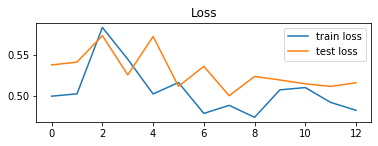

In [31]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()

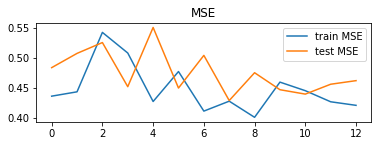

In [32]:
plt.subplot(212)
plt.title('MSE')
plt.plot(history.history['mse'], label='train MSE')
plt.plot(history.history['val_mse'], label='test MSE')
plt.legend()

# 4. Postprocessing of results with KernelExplainer

In [33]:
shap.initjs()  # initialize SHAP visualizations

## 4.1 Choice of background dataset
Use different options for background dataset. The results show that, at least for > `nsamples=250`, the choice does not matter.

In [34]:
check_background = False

# --- Check for different background dataset options
if check_background:
    background_data_sample250 = shap.sample(X, 250)    
    background_data_sample200 = shap.sample(X, 200)
    background_data_sample100 = shap.sample(X, 100)    
    background_data_sample50 = shap.sample(X, 100)    
    background_data_kmeans250 = shap.kmeans(X, 250)    
    background_data_kmeans200 = shap.kmeans(X, 200)
    background_data_kmeans100 = shap.kmeans(X, 100)    
    background_data_kmeans50 = shap.kmeans(X, 50)

    # list of background datasets to cycle through
    background_data = [background_data_sample250, background_data_sample200, background_data_sample100, background_data_sample50,
                       background_data_kmeans250, background_data_kmeans200, background_data_kmeans100, background_data_kmeans50]
    background_data.reverse()  # reverse list to start with smallest k-means set

    # loop through different background sets and show rankings
    for bg_data_set in background_data:
        explainer = shap.KernelExplainer(model.predict, data=bg_data_set)  
        shap_values_nsamples = explainer.shap_values(X, nsamples=250, l1_reg='aic')
        f = plt.figure(figsize=fig_size_)
        f = shap.summary_plot(shap_values_nsamples, X, plot_type="bar", show=False, plot_size=None)
        plt.show

# --- or use one option
else:
    if freshwater_:  # Because the freshwater data set is small, take the whole data
        background_data = X
    else:            # The saltwater data set is big, so take n samples as representative data set
        background_data = shap.kmeans(X, 200)  

# Initiate explainer and calculate shap values.
explainer = shap.KernelExplainer(model.predict, data=background_data)  

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## 4.2 Choice of `nsamples`
Use one option for the background dataset but vary `nsamples`.

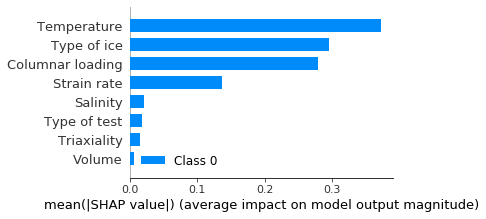

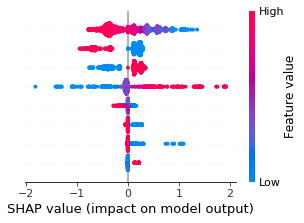

In [35]:
vary_nsamples = False  

# --- Check different choices of nsamples
if vary_nsamples: 
    nsamples_n = [50, 100, 150, 200, 250, 375, 500]  # number of nsamples to cycle through
    for nsamples_ in nsamples_n:
        shap_values_nsamples = explainer.shap_values(X, nsamples=nsamples_, l1_reg='aic')  # calculate shap values with different nsamples
        f = plt.figure(figsize=fig_size_)  # show different rankings to check for differences
        f = shap.summary_plot(shap_values_nsamples, X, plot_type="bar", show=False, plot_size=None)
        plt.show
        
# --- Use a fixed number of nsamples     
else:  
    shap_values = explainer.shap_values(X, nsamples=500, l1_reg='aic')  # with setting nsamples
    # nsamples : "auto" or int. Number of times to re-evaluate the model when explaining each prediction.
    # without setting nsamples, nsamples = 2 * X.shape[1] + 2048
    # X: A matrix of samples (# samples x # features) on which to explain the model's output.
    
    # plot  
    f = plt.figure(figsize=fig_size_)
    f = shap.summary_plot(shap_values, X, feature_names=display_feature_names, plot_type="bar", show=False, plot_size=None)
    plt.show

    f = plt.figure(figsize=fig_size_)
    f = shap.summary_plot(shap_values[0], X, feature_names=["" for m in display_feature_names], plot_type="dot", show=False, plot_size=None)
    plt.show

Save final ranking and summary plot

<function matplotlib.pyplot.show(*args, **kw)>

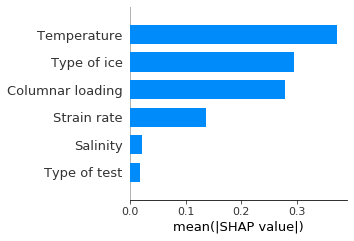

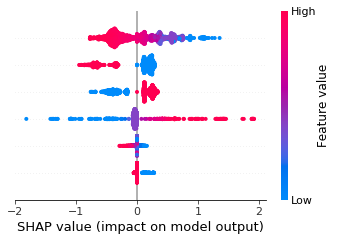

In [36]:
# plot and save 
max_display_ = 6
f = plt.figure(figsize=fig_size_)
f = shap.summary_plot(shap_values[0], X, feature_names=display_feature_names, plot_type="bar", 
                      show=False, plot_size=None, max_display=max_display_)
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "ranking_bar.pdf", format='pdf', dpi=dpi_)  
plt.show

f = plt.figure(figsize=fig_size_)
f = shap.summary_plot(shap_values[0], X, feature_names=["" for m in display_feature_names], plot_type="dot", 
                      show=False, plot_size=None, max_display=max_display_)
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "summary.pdf", dpi=dpi_, format='pdf')
plt.show